In [1]:
import matplotlib
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
device = "cuda"
dtype = torch.float32

## Data

In [2]:
ethanol = np.load("md17_ethanol.npz")

In [3]:
ethanol.files

['E', 'name', 'F', 'theory', 'R', 'z', 'type', 'md5']

In [4]:
z = ethanol['z']

In [5]:
pos = ethanol['R'][0]

In [6]:
z

array([6, 6, 8, 1, 1, 1, 1, 1, 1], dtype=uint8)

In [7]:
pos

array([[ 0.0072, -0.5687,  0.    ],
       [-1.2854,  0.2499,  0.    ],
       [ 1.1304,  0.3147,  0.    ],
       [ 0.0392, -1.1972,  0.89  ],
       [ 0.0392, -1.1972, -0.89  ],
       [-1.3175,  0.8784,  0.89  ],
       [-1.3175,  0.8784, -0.89  ],
       [-2.1422, -0.4239,  0.    ],
       [ 1.9857, -0.1365,  0.    ]])

## Embedding

### Generate RBF from displacement vectors

In [8]:
R = np.zeros((9, 9, 3))

for i, r1 in enumerate(pos):
    for j, r2 in enumerate(pos):
        if i != j:
            R[i, j] = (r2 - r1) / np.linalg.norm(r2 - r1)
        else:
            R[i, j] = (r2 - r1)

R = torch.from_numpy(R)

**lower limit of cutoff is not considered here**

In [9]:
def radial_basis_func(r_ij, r_c, num_rbf):
    RBF = np.zeros((1, num_rbf), dtype=np.float32)
    mu = np.linspace(np.exp(-r_c), 1, num_rbf, dtype=np.float32)
    beta = np.power(2/num_rbf * (1 - np.exp(-r_c)), -2, dtype=np.float32)

    for k, mu_k in enumerate(mu):
        RBF[0, k] = np.exp(-1 * beta * np.power((np.exp(-r_ij) - mu[k]), 2))

    RBF = torch.from_numpy(RBF)

    return RBF

def phi(r_ij, r_c):
    if r_ij < r_c:
        phi = (1/2) * (np.cos(np.pi * r_ij / r_c) + 1)
    else:
        phi = 0

    return phi

In [10]:
r_ij = np.linalg.norm(R[0, 1])
r_c = 5
num_rbf = 1000

RBF = radial_basis_func(r_ij, r_c, num_rbf)

In [11]:
RBF

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e

In [12]:
phi(r_ij, r_c)

0.9045084971874737

### Make a plot RBF-mu

In [13]:
mu = np.linspace(np.exp(-r_c), 1, num_rbf, dtype=np.float32)

In [14]:
mu

array([0.00673795, 0.0077322 , 0.00872646, 0.00972072, 0.01071497,
       0.01170923, 0.01270348, 0.01369774, 0.014692  , 0.01568625,
       0.01668051, 0.01767477, 0.01866902, 0.01966328, 0.02065754,
       0.02165179, 0.02264605, 0.0236403 , 0.02463456, 0.02562882,
       0.02662307, 0.02761733, 0.02861159, 0.02960584, 0.0306001 ,
       0.03159435, 0.03258861, 0.03358287, 0.03457712, 0.03557138,
       0.03656564, 0.03755989, 0.03855415, 0.0395484 , 0.04054266,
       0.04153692, 0.04253117, 0.04352543, 0.04451969, 0.04551394,
       0.0465082 , 0.04750245, 0.04849671, 0.04949097, 0.05048522,
       0.05147948, 0.05247374, 0.05346799, 0.05446225, 0.05545651,
       0.05645076, 0.05744502, 0.05843927, 0.05943353, 0.06042779,
       0.06142204, 0.0624163 , 0.06341056, 0.06440482, 0.06539907,
       0.06639332, 0.06738758, 0.06838184, 0.0693761 , 0.07037035,
       0.0713646 , 0.07235886, 0.07335312, 0.07434738, 0.07534163,
       0.07633589, 0.07733014, 0.0783244 , 0.07931866, 0.08031

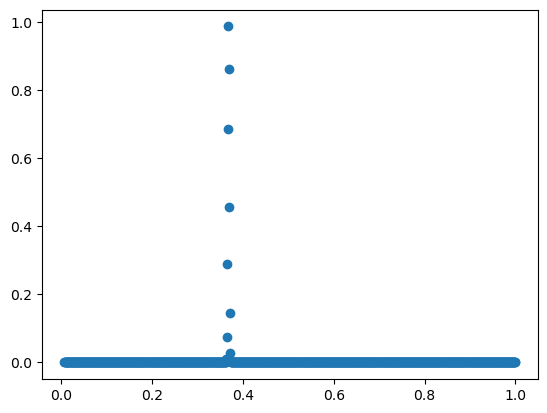

In [15]:
plt.scatter(mu, RBF.numpy())

### Tensor decomposition

**I_0 doesn't match original implementation (which is simply I)**

In [16]:
def vector_to_X(v):
    vvT = torch.outer(v, v)
    I = torch.eye(3) * (2/3) * torch.pow(torch.norm(v), 2)
    A = torch.Tensor(
        [
            [0, v[2], -v[1]],
            [-v[2], 0, v[0]],
            [v[1], -v[0], 0]
        ]
    )
    X = A + vvT

    return X

def decompose_X(X):
    I = (1/3) * torch.eye(3) * torch.trace(X)
    A = (1/2) * (X - X.T)
    S = (1/2) * (X + X.T - (2/3) * torch.eye(3) * torch.trace(X))

    return I, A, S


In [17]:
tensor = torch.eye(3)

In [18]:
X = vector_to_X(R[0, 1])
I, A, S = decompose_X(X)

In [19]:
I

tensor([[0.3333, 0.0000, 0.0000],
        [0.0000, 0.3333, 0.0000],
        [0.0000, 0.0000, 0.3333]])

In [20]:
A

tensor([[ 0.0000,  0.0000, -0.5350],
        [ 0.0000,  0.0000, -0.8448],
        [ 0.5350,  0.8448,  0.0000]], dtype=torch.float64)

In [21]:
S

tensor([[ 0.3804, -0.4520,  0.0000],
        [-0.4520, -0.0471,  0.0000],
        [ 0.0000,  0.0000, -0.3333]], dtype=torch.float64)

### Atomic number embeddings

In [22]:
atomic_numbers = torch.tensor([6, 1], dtype=torch.long)
max_z = 128
hidden_channels = 5

emb = nn.Embedding(max_z, hidden_channels)
emb2 = nn.Linear(2 * hidden_channels, hidden_channels)

Z = emb(atomic_numbers)
Z = Z.reshape(1, -1)
Zij = emb2(Z)

In [23]:
Z

tensor([[ 0.1628, -0.0334, -0.8199,  1.2724,  0.9792,  0.6401,  0.7564, -0.6928,
          0.5977, -0.3304]], grad_fn=<ViewBackward0>)

In [24]:
Zij

tensor([[ 0.3616, -0.4023,  0.4757,  0.4644,  0.0259]],
       grad_fn=<AddmmBackward0>)

### Calculate embedding tensor X(ij)

In [25]:
f_I = nn.Linear(num_rbf, hidden_channels, dtype=dtype)
f_A = nn.Linear(num_rbf, hidden_channels, dtype=dtype)
f_S = nn.Linear(num_rbf, hidden_channels, dtype=dtype)

In [26]:
I_0, A_0, S_0 = decompose_X(vector_to_X(R[0, 1]))

# duplicate for hidden channels
I_0 = I_0.repeat(1, hidden_channels, 1, 1)
A_0 = A_0.repeat(1, hidden_channels, 1, 1)
S_0 = S_0.repeat(1, hidden_channels, 1, 1)

Iij = (phi(r_ij, r_c) * Zij * f_I(RBF) * (I_0.permute(2, 3, 0, 1))).permute(2, 3, 0, 1)
Aij = (phi(r_ij, r_c) * Zij * f_A(RBF) * (A_0.permute(2, 3, 0, 1))).permute(2, 3, 0, 1)
Sij = (phi(r_ij, r_c) * Zij * f_A(RBF) * (S_0.permute(2, 3, 0, 1))).permute(2, 3, 0, 1)

In [27]:
I_0.shape

torch.Size([1, 5, 3, 3])

In [28]:
f_I(RBF).shape

torch.Size([1, 5])

In [29]:
Zij.shape

torch.Size([1, 5])

In [30]:
RBF.shape

torch.Size([1, 1000])

In [31]:
(Zij * I_0.permute(2, 3, 0, 1)).shape

torch.Size([3, 3, 1, 5])

### Calculate embedding tensor X(0) for one atom 0 (Carbon)

In [32]:
# model set up
r_c = 5
num_rbf = 10
hidden_channels = 5
max_z = 128

I = torch.zeros((len(z), hidden_channels, 3, 3), dtype=dtype)
A = torch.zeros((len(z), hidden_channels, 3, 3), dtype=dtype)
S = torch.zeros((len(z), hidden_channels, 3, 3), dtype=dtype)

for i, atomic_number in enumerate(z):
    r_ij = np.linalg.norm(R[0, i])
    RBF = radial_basis_func(r_ij, r_c, num_rbf)
    
    # Zij
    atomic_numbers = torch.tensor([z[0], z[i]], dtype=torch.long)
    Z = emb(atomic_numbers)
    Z = Z.reshape(1, -1)
    Zij = emb2(Z)

    # init I, A, S
    f_I = nn.Linear(num_rbf, hidden_channels, dtype=dtype)
    f_A = nn.Linear(num_rbf, hidden_channels, dtype=dtype)
    f_S = nn.Linear(num_rbf, hidden_channels, dtype=dtype)
    I_0, A_0, S_0 = decompose_X(vector_to_X(R[0, 1]))

    # duplicate for hidden channels
    I_0 = I_0.repeat(1, hidden_channels, 1, 1)
    A_0 = A_0.repeat(1, hidden_channels, 1, 1)
    S_0 = S_0.repeat(1, hidden_channels, 1, 1)
    
    Iij = (phi(r_ij, r_c) * Zij * f_I(RBF) * (I_0.permute(2, 3, 0, 1))).permute(2, 3, 0, 1)
    Aij = (phi(r_ij, r_c) * Zij * f_A(RBF) * (A_0.permute(2, 3, 0, 1))).permute(2, 3, 0, 1)
    Sij = (phi(r_ij, r_c) * Zij * f_A(RBF) * (S_0.permute(2, 3, 0, 1))).permute(2, 3, 0, 1)
    
    I[i] = Iij[0]
    A[i] = Aij[0]
    S[i] = Sij[0]


In [33]:
I.shape

torch.Size([9, 5, 3, 3])

In [34]:
# eqn(9)
def tensor_norm(tensor):
    """Computes Frobenius norm."""
    return (tensor**2).sum((-2, -1))

init_norm = nn.LayerNorm(hidden_channels, dtype=dtype)
norm = init_norm(tensor_norm(I + A + S))

linears_scalar = nn.ModuleList()
linears_scalar.append(
    nn.Linear(hidden_channels, 2 * hidden_channels, bias=True, dtype=dtype)
)
linears_scalar.append(
    nn.Linear(2 * hidden_channels, 3 * hidden_channels, bias=True, dtype=dtype)
)

activation = nn.SiLU()

for linear_scalar in linears_scalar:
    norm = activation(linear_scalar(norm))

In [35]:
norm.shape

torch.Size([9, 15])

In [36]:
norm = norm.reshape(-1, hidden_channels, 3)

In [37]:
norm.shape

torch.Size([9, 5, 3])

In [38]:
# eqn(10)
linears_tensor = nn.ModuleList()
for _ in range(3):
    linears_tensor.append(
        nn.Linear(hidden_channels, hidden_channels, bias=False)
    )

I = linears_tensor[0](I.permute(0, 2, 3, 1)).permute(0, 3, 1, 2) * norm[..., 0, None, None]
A = linears_tensor[1](A.permute(0, 2, 3, 1)).permute(0, 3, 1, 2) * norm[..., 0, None, None]
S = linears_tensor[2](S.permute(0, 2, 3, 1)).permute(0, 3, 1, 2) * norm[..., 0, None, None]

X = I + A + S

In [39]:
linears_tensor[0](I.permute(0, 2, 3, 1)).shape

torch.Size([9, 3, 3, 5])

In [40]:
norm[..., 0, None, None].shape

torch.Size([9, 5, 1, 1])

In [41]:
X.shape

torch.Size([9, 5, 3, 3])

In [42]:
I.permute(0, 2, 3, 1).shape

torch.Size([9, 3, 3, 5])

## Interaction

In [43]:
X = X / (tensor_norm(X) + 1)[..., None, None]

I = X.clone().detach()
A = X.clone().detach()
S = X.clone().detach()

for i in range(len(z)):
    for j in range(hidden_channels):
        I[i, j], A[i, j], S[i, j] = decompose_X(X[i, j])

### Compare results with original implementation

In [44]:
def decompose_tensor(tensor):
    """Full tensor decomposition into irreducible components."""
    I = (tensor.diagonal(offset=0, dim1=-1, dim2=-2)).mean(-1)[
        ..., None, None
    ] * torch.eye(3, 3, device=tensor.device, dtype=tensor.dtype)
    A = 0.5 * (tensor - tensor.transpose(-2, -1))
    S = 0.5 * (tensor + tensor.transpose(-2, -1)) - I
    return I, A, S

In [45]:
II, AA, SS = decompose_tensor(X)

In [46]:
assert torch.allclose(I, II)

In [47]:
assert torch.allclose(A, AA)

In [48]:
assert torch.allclose(S, SS)

### Y(i)

In [49]:
linears_tensor = nn.ModuleList()
for _ in range(6):
    linears_tensor.append(
        nn.Linear(hidden_channels, hidden_channels, bias=False)
    )

In [50]:
I = linears_tensor[0](I.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
A = linears_tensor[1](A.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
S = linears_tensor[2](S.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
Y = I + A + S

### M(i)

In [51]:
def tensor_embedding(j):
    # model set up
    r_c = 5
    num_rbf = 10
    hidden_channels = 5
    max_z = 128

    I = torch.zeros((len(z), hidden_channels, 3, 3), dtype=dtype)
    A = torch.zeros((len(z), hidden_channels, 3, 3), dtype=dtype)
    S = torch.zeros((len(z), hidden_channels, 3, 3), dtype=dtype)
    
    for i, atomic_number in enumerate(z):
        r_ij = np.linalg.norm(R[j, i])
        RBF = radial_basis_func(r_ij, r_c, num_rbf)
        
        # Zij
        atomic_numbers = torch.tensor([z[j], z[i]], dtype=torch.long)
        Z = emb(atomic_numbers)
        Z = Z.reshape(1, -1)
        Zij = emb2(Z)
    
        # init I, A, S
        f_I = nn.Linear(num_rbf, hidden_channels, dtype=dtype)
        f_A = nn.Linear(num_rbf, hidden_channels, dtype=dtype)
        f_S = nn.Linear(num_rbf, hidden_channels, dtype=dtype)
        I_0, A_0, S_0 = decompose_X(vector_to_X(R[j, 1]))
    
        # duplicate for hidden channels
        I_0 = I_0.repeat(1, hidden_channels, 1, 1)
        A_0 = A_0.repeat(1, hidden_channels, 1, 1)
        S_0 = S_0.repeat(1, hidden_channels, 1, 1)
        
        Iij = (phi(r_ij, r_c) * Zij * f_I(RBF) * (I_0.permute(2, 3, 0, 1))).permute(2, 3, 0, 1)
        Aij = (phi(r_ij, r_c) * Zij * f_A(RBF) * (A_0.permute(2, 3, 0, 1))).permute(2, 3, 0, 1)
        Sij = (phi(r_ij, r_c) * Zij * f_S(RBF) * (S_0.permute(2, 3, 0, 1))).permute(2, 3, 0, 1)
        
        I[i] = Iij[0]
        A[i] = Aij[0]
        S[i] = Sij[0]

    # eqn(9)
    init_norm = nn.LayerNorm(hidden_channels, dtype=dtype)
    norm = init_norm(tensor_norm(I + A + S))
    
    linears_scalar = nn.ModuleList()
    linears_scalar.append(
        nn.Linear(hidden_channels, 2 * hidden_channels, bias=True, dtype=dtype)
    )
    linears_scalar.append(
        nn.Linear(2 * hidden_channels, 3 * hidden_channels, bias=True, dtype=dtype)
    )
    
    activation = nn.SiLU()
    
    for linear_scalar in linears_scalar:
        norm = activation(linear_scalar(norm))

    norm = norm.reshape(-1, hidden_channels, 3)

    # eqn(10)
    local_linears_tensor = nn.ModuleList()
    for _ in range(3):
        local_linears_tensor.append(
            nn.Linear(hidden_channels, hidden_channels, bias=False)
        )

    I = local_linears_tensor[0](I.permute(0, 2, 3, 1)).permute(0, 3, 1, 2) * norm[..., 0, None, None]
    A = local_linears_tensor[1](A.permute(0, 2, 3, 1)).permute(0, 3, 1, 2) * norm[..., 0, None, None]
    S = local_linears_tensor[2](S.permute(0, 2, 3, 1)).permute(0, 3, 1, 2) * norm[..., 0, None, None]
    
    X = I + A + S


    return X


In [52]:
Im = torch.zeros((len(z), hidden_channels, 3, 3), dtype=dtype)
Am = torch.zeros((len(z), hidden_channels, 3, 3), dtype=dtype)
Sm = torch.zeros((len(z), hidden_channels, 3, 3), dtype=dtype)

linears_scalar = nn.ModuleList()
linears_scalar.append(
    nn.Linear(num_rbf, hidden_channels, bias=True, dtype=dtype)
)
linears_scalar.append(
    nn.Linear(hidden_channels, 2 * hidden_channels, bias=True, dtype=dtype)
)
linears_scalar.append(
    nn.Linear(2 * hidden_channels, 3 * hidden_channels, bias=True, dtype=dtype)
)

for i, atomic_number in enumerate(z):
    r_ij = np.linalg.norm(R[0, i])
    RBF = radial_basis_func(r_ij, r_c, num_rbf)

    for linear_scalar in linears_scalar:
        RBF = activation(linear_scalar(RBF))
    f = phi(r_ij, r_c) * RBF
    f = f.reshape((1, -1, 3)) # last dimention will be separated into f_I, f_A, f_S

    print(i)
    Ij, Aj, Sj = decompose_tensor(tensor_embedding(i))
    
    Im = Im + (f[..., 0] * Ij.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
    Am = Am + (f[..., 1] * Aj.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
    Sm = Sm + (f[..., 0] * Sj.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)

0
1
2
3
4
5
6
7
8


In [53]:
Im.shape

torch.Size([9, 5, 3, 3])

In [54]:
f.shape

torch.Size([1, 5, 3])

In [55]:
tensor_embedding(1).shape

torch.Size([9, 5, 3, 3])

In [56]:
M = Im + Am + Sm

### Update X

**What is total charge q?**

In [57]:
A = torch.matmul(M, Y)
B = torch.matmul(Y, M)
I, A, S = decompose_tensor(A + B)

normp1 = (tensor_norm(I + A + S) + 1)[..., None, None]
I, A, S = I / normp1, A / normp1, S / normp1
I = linears_tensor[3](I.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
A = linears_tensor[4](A.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
S = linears_tensor[5](S.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
dX = I + A + S
X = X + dX + torch.matrix_power(dX, 2)

In [58]:
X.shape

torch.Size([9, 5, 3, 3])